<a href="https://colab.research.google.com/github/ArjunNarayan2066/Test/blob/master/A2Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
!pip install ipympl
import ipympl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
# make it easier to understand by importing the required libraries within keras
from tensorflow.keras.layers import Dense, Flatten

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

np.random.seed(1)
np.set_printoptions(suppress=True)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Fetch the raw data once from the file
rawdata = np.genfromtxt('diabetes.csv', delimiter=',')
print(rawdata.shape)
data = rawdata[1:]
fields = data[:,:-1]
labels = data[:,-1].astype(np.int)
print(fields.shape)
print(labels.shape)


(769, 9)
(768, 8)
(768,)


In [4]:
# # Preprocess data into 80% of both 1 & 0 cases
# # Normalize data to between 1 & 0 in each field
# fields_max = fields.max(axis=0)
# norm_fields = fields / fields_max

# training_split = 0.8

# # Split into training & testing data
# label1_idx = np.where(labels == 1)[0]
# label0_idx = np.where(labels == 0)[0]
# label1_count = len(label1_idx)
# label0_count = len(label0_idx)
# train_size_1 = int(label1_count*training_split)
# train_size_0 = int(label0_count*training_split)

# # Fetch indices of training & testing data
# train_idx_1 = label1_idx[:train_size_1]
# train_idx_0 = label0_idx[:train_size_0]
# test_idx_1 = label1_idx[train_size_1:]
# test_idx_0 = label0_idx[train_size_0:]

# # Combine 1 & 0 cases to single array of indices
# train_idx = np.concatenate((train_idx_1, train_idx_0))
# test_idx = np.concatenate((test_idx_1, test_idx_0))

# # Final normalized & separated training & testing data
# train_data = norm_fields[train_idx]
# train_labels = labels[train_idx]
# test_data = norm_fields[test_idx]
# test_labels = labels[test_idx]

# print(train_data.shape)
# print(test_labels.shape)

In [5]:
# Normalize the data
norm_fields = (fields - fields.min(axis=0)) / (fields.max(axis=0) - fields.min(axis=0))

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)

# Split the data into training and testing
train_fields, test_fields, train_labels, test_labels = train_test_split(norm_fields, labels, test_size=0.20)

train_labels_enc = encoder.fit_transform(train_labels.reshape(-1,1))
test_labels_enc = encoder.fit_transform(test_labels.reshape(-1,1))

print(train_labels.shape)
print(test_labels.shape)

print("Sample train data: {}".format(train_labels_enc[:3]))
print("Sample train labels: {}".format(test_labels_enc[:3]))

(614,)
(154,)
Sample train data: [[0. 1.]
 [0. 1.]
 [1. 0.]]
Sample train labels: [[1. 0.]
 [1. 0.]
 [1. 0.]]


In [7]:
# General training code for Question 3 functions

val_err_callback = keras.callbacks.EarlyStopping(monitor='val_loss', baseline=0.06, patience=150, mode="min") 
callbacks = [val_err_callback]
kernel=keras.initializers.RandomNormal(mean=0., stddev=10)
bias=keras.initializers.RandomNormal(mean=0., stddev=10)

def train_kfold(layers, K, batch=1, lr = 0.005):
    best_history = None
    best_loss = 1e6 # Something big
    best_model = None
    fig_count = 0
    rolls = [len(s) for s in np.array_split(np.arange(len(train_labels)), K)]
    print(rolls)
    print(1.0/K)

    with tf.device('/device:GPU:0'):
        folded_fields = np.copy(train_fields)
        folded_labels = np.copy(train_labels_enc)

        # Apply K-fold cross validation
        val_split = 1.0/K
        for k in range(K):
            test_model = keras.models.Sequential()
            test_model.add(Dense(layers[0], activation='sigmoid', input_shape=(8,)))
            for l in layers[1:]:
                test_model.add(Dense(l, activation='sigmoid'))
            test_model.add(Dense(2, activation='softmax'))     
            test_model.compile(loss='categorical_crossentropy',  metrics=['accuracy'], 
                            optimizer=keras.optimizers.Adam(learning_rate=lr))
                       
            h = test_model.fit(folded_fields, folded_labels, 
                        epochs=1000, batch_size=batch, validation_split=val_split, 
                        verbose=1, callbacks=callbacks)
            # Plot Results in Real Time
            plt.figure(fig_count)
            fig_count += 1
            plt.plot(h.history['loss'], 'b')
            plt.plot(h.history['val_loss'], 'r')
            plt.legend(['Training Loss', 'Validation Loss'])

            # Save the current values
            print("      Fold {} -- Train Err {} -- Val Err {}".format(k, h.history['loss'][-1], h.history['val_loss'][-1]))
            # Cycle the dataset, move the next 10% into the last spot to then cross-validate with the next fold
            folded_fields = np.roll(folded_fields, rolls[k])
            folded_labels = np.roll(folded_labels, rolls[k])

            if h.history['val_loss'][-1] < best_loss:
                best_loss = h.history['val_loss'][-1]
                best_history = h.history
           
                best_model = keras.models.clone_model(test_model)
                best_model.build((None, 8))
                best_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
                best_model.set_weights(test_model.get_weights())
    
    print("Best Validation Loss: {}".format(best_loss))
    return best_history, best_model


### Model 1

[123, 123, 123, 123, 122]
0.2
Epoch 1/1000
25/25 [==============================] - 1s 20ms/step - loss: 0.6724 - accuracy: 0.5933 - val_loss: 0.6650 - val_accuracy: 0.6341
Epoch 2/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6563 - accuracy: 0.6591 - val_loss: 0.6577 - val_accuracy: 0.6341
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.6465 - val_loss: 0.6587 - val_accuracy: 0.6341
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6476 - val_loss: 0.6478 - val_accuracy: 0.6341
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6615 - val_loss: 0.6353 - val_accuracy: 0.6341
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6487 - val_loss: 0.6068 - val_accuracy: 0.6341
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6028 - accuracy: 0.6864 - val_loss: 0.573

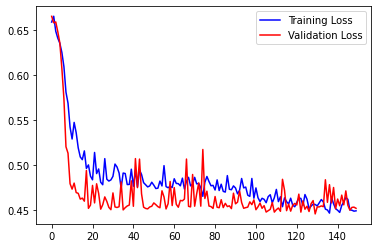

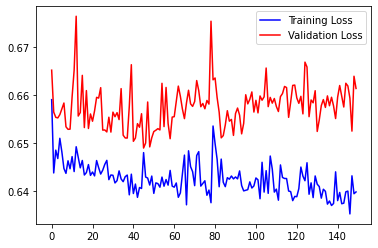

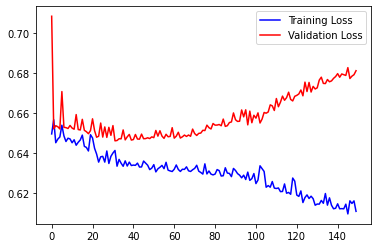

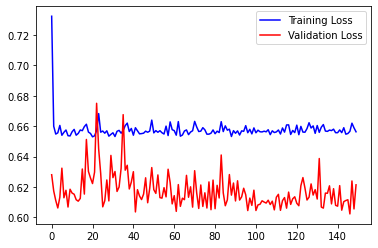

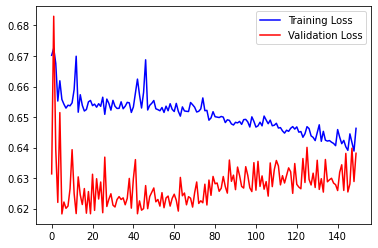

In [8]:
%%time

# model_1 = keras.models.Sequential([
#     Dense(60, activation='sigmoid', input_shape=(8,)),
#     Dense(40, activation='sigmoid'),
#     Dense(20, activation='sigmoid'),
#     Dense(2, activation='softmax')
# ])
hist_1, model_1 = train_kfold([60, 40, 20], 5, batch=20, lr=0.007)

5/5 [==============================] - 0s 2ms/step - loss: 0.4168 - accuracy: 0.8326

Test accuracy: 0.8181818127632141

Test loss:  0.44525468349456787


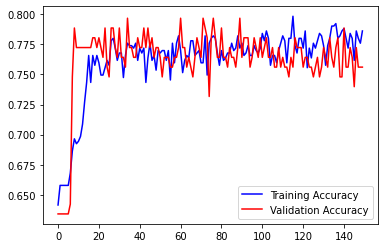

In [9]:
plt.figure(6)
plt.plot(hist_1['accuracy'], 'b')
plt.plot(hist_1['val_accuracy'], 'r')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

results = model_1.evaluate(test_fields,  test_labels_enc, return_dict=True)
print('\nTest accuracy:', results['accuracy'])
print('\nTest loss: ', results['loss'])

[[88 11]
 [17 38]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        99
           1       0.78      0.69      0.73        55

    accuracy                           0.82       154
   macro avg       0.81      0.79      0.80       154
weighted avg       0.82      0.82      0.82       154



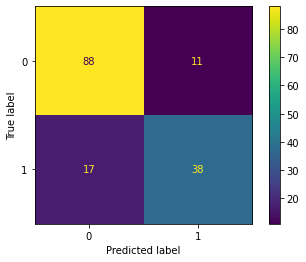

In [10]:
y_mlp = np.argmax(model_1.predict(test_fields), axis=-1)
cm_mlp = confusion_matrix(test_labels, y_mlp)
print(cm_mlp)
print(classification_report(test_labels, y_mlp, target_names= ['0', '1']))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_mlp,display_labels=['0', '1'])
disp1.plot()

### Model 2

[123, 123, 123, 123, 122]
0.2
Epoch 1/1000
164/164 [==============================] - 1s 4ms/step - loss: 0.6810 - accuracy: 0.6337 - val_loss: 0.6588 - val_accuracy: 0.6341
Epoch 2/1000
164/164 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6829 - val_loss: 0.6612 - val_accuracy: 0.6341
Epoch 3/1000
164/164 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.6324 - val_loss: 0.6579 - val_accuracy: 0.6341
Epoch 4/1000
164/164 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6513 - val_loss: 0.6964 - val_accuracy: 0.6341
Epoch 5/1000
164/164 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6666 - val_loss: 0.6582 - val_accuracy: 0.6341
Epoch 6/1000
164/164 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6396 - val_loss: 0.6519 - val_accuracy: 0.6341
Epoch 7/1000
164/164 [==============================] - 0s 3ms/step - loss: 0.5413 - accuracy: 0.7000 - va

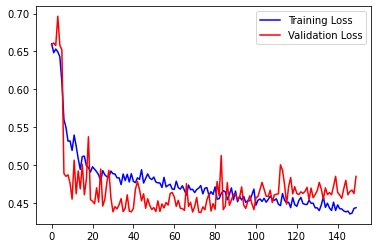

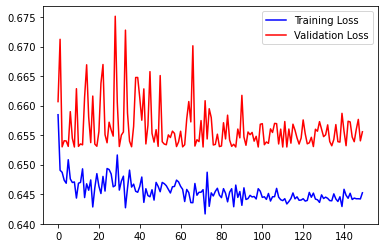

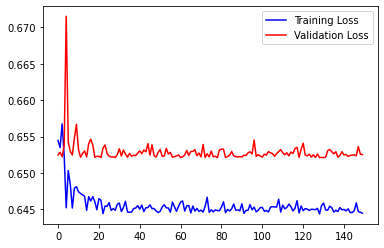

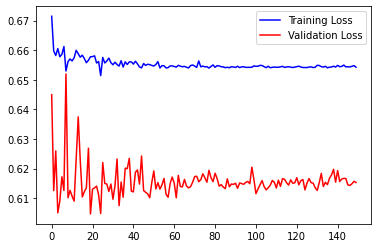

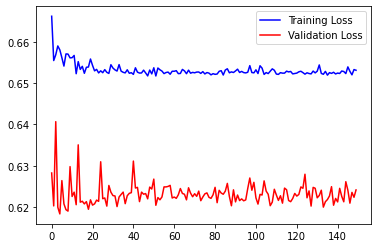

In [11]:
%%time

# model_2 = keras.models.Sequential([
#     Dense(120, activation='sigmoid', input_shape=(8,)),
#     Dense(70, activation='sigmoid'),
#     Dense(40, activation='sigmoid'),
#     Dense(20, activation='sigmoid')
#     Dense(2, activation='softmax')
# ])
hist_2, model_2 = train_kfold([120, 70, 40, 20], 5, batch=3, lr=0.003)

5/5 [==============================] - 0s 3ms/step - loss: 0.4394 - accuracy: 0.8431

Test accuracy: 0.8051947951316833

Test loss:  0.4818299114704132
[[90  9]
 [21 34]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        99
           1       0.79      0.62      0.69        55

    accuracy                           0.81       154
   macro avg       0.80      0.76      0.78       154
weighted avg       0.80      0.81      0.80       154



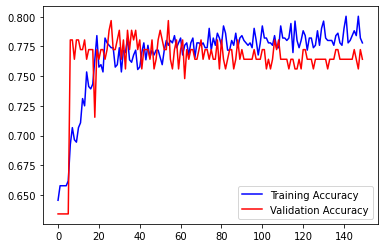

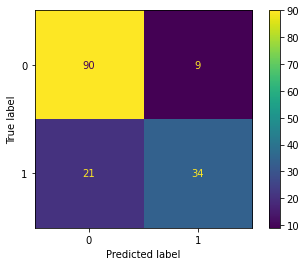

In [12]:
plt.figure(10)
plt.plot(hist_2['accuracy'], 'b')
plt.plot(hist_2['val_accuracy'], 'r')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

results = model_2.evaluate(test_fields,  test_labels_enc, return_dict=True)
print('\nTest accuracy:', results['accuracy'])
print('\nTest loss: ', results['loss'])


y_mlp = np.argmax(model_2.predict(test_fields), axis=-1)
cm_mlp = confusion_matrix(test_labels, y_mlp)
print(cm_mlp)
print(classification_report(test_labels, y_mlp, target_names= ['0', '1']))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_mlp,display_labels=['0', '1'])
disp1.plot()

## Model 3

[123, 123, 123, 123, 122]
0.2
Epoch 1/1000
17/17 [==============================] - 1s 14ms/step - loss: 0.6763 - accuracy: 0.6512 - val_loss: 0.6518 - val_accuracy: 0.6341
Epoch 2/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.6421 - accuracy: 0.6597 - val_loss: 0.6477 - val_accuracy: 0.6341
Epoch 3/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.6415 - accuracy: 0.6496 - val_loss: 0.6453 - val_accuracy: 0.6341
Epoch 4/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.6238 - accuracy: 0.6684 - val_loss: 0.6374 - val_accuracy: 0.6341
Epoch 5/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.6369 - accuracy: 0.6414 - val_loss: 0.6353 - val_accuracy: 0.6341
Epoch 6/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.6176 - accuracy: 0.6619 - val_loss: 0.6216 - val_accuracy: 0.6341
Epoch 7/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.6240 - accuracy: 0.6442 - val_loss: 0.615

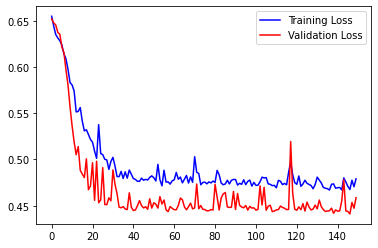

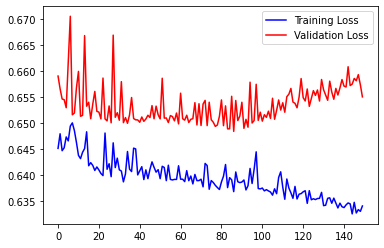

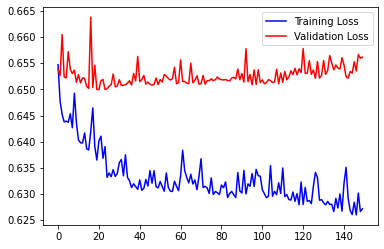

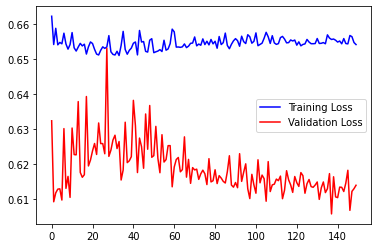

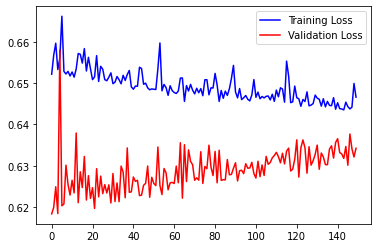

In [13]:
%%time

# model_3 = keras.models.Sequential([
#     Dense(40, activation='sigmoid', input_shape=(8,)),
#     Dense(10, activation='sigmoid')
#     Dense(2, activation='softmax')
# ])
hist_3, model_3 = train_kfold([40, 10], 5, batch=30, lr=0.007)

5/5 [==============================] - 0s 3ms/step - loss: 0.4638 - accuracy: 0.8136

Test accuracy: 0.7857142686843872

Test loss:  0.4976707994937897
[[92  7]
 [26 29]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        99
           1       0.81      0.53      0.64        55

    accuracy                           0.79       154
   macro avg       0.79      0.73      0.74       154
weighted avg       0.79      0.79      0.77       154



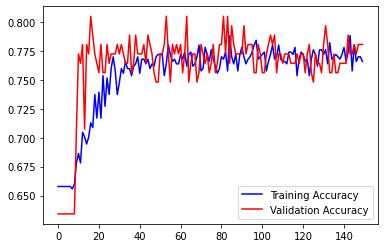

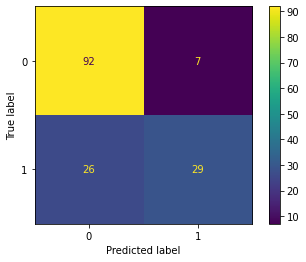

In [14]:
plt.figure(14)
plt.plot(hist_3['accuracy'], 'b')
plt.plot(hist_3['val_accuracy'], 'r')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

results = model_3.evaluate(test_fields,  test_labels_enc, return_dict=True)
print('\nTest accuracy:', results['accuracy'])
print('\nTest loss: ', results['loss'])


y_mlp = np.argmax(model_3.predict(test_fields), axis=-1)
cm_mlp = confusion_matrix(test_labels, y_mlp)
print(cm_mlp)
print(classification_report(test_labels, y_mlp, target_names= ['0', '1']))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_mlp,display_labels=['0', '1'])
disp1.plot()